In [1]:
import pandas as pd
import numpy as np
import psycopg2
import pyodbc
import mysql.connector
import json
import matplotlib.pyplot as plt
import seaborn as sns
from decimal import Decimal

import requests
import datetime
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [2]:
pyodbc.drivers()

['MySQL']

### Redshift Connection

In [3]:
# Redshift 연결 정보
host=''
dbname=''
user=''
password=''
port=''

In [4]:
# Redshift에 연결
conn = psycopg2.connect(
    host=host,
    dbname=dbname,
    user=user,
    password=password,
    port=port
)

In [5]:
# 커서 생성
cursor = conn.cursor()
# SQL 쿼리 실행 (예시: frigga_sample 테이블에서 모든 데이터를 조회)
cursor.execute("""
                SELECT
                    device_datetime_kor, device_serial, lat, lon, battery, temperature, humidity
                    , acc_orig, acc, accx, accy, accz, tiltx, tilty, tiltz
                    , measure_date_kst, aws_station_id, aws_station_name, aws_lat, aws_lon, distance_km, ws1, ws10, ta, hm
                FROM 
                    "data_analysis_db"."da_schema"."t_frigga_weather_map"
                WHERE 1=1
                    AND temperature IS NOT NULL
                    AND acc_orig IS NOT NULL
                    AND distance_km <= 10
                    ORDER BY distance_km DESC
               """)

# 결과 가져오기
rows = cursor.fetchall()

cursor.close()
conn.close()

In [6]:
# 컬럼명 리스트 정의
columns = ['device_datetime_kor', 'device_serial', 'lat', 'lon', 'battery', 'temperature', 'humidity', 'acc_orig',
           'acc', 'accx', 'accy', 'accz', 'tiltx', 'tilty', 'tiltz', 
           'measure_date_kst', 'aws_station_id', 'aws_station_name', 'aws_lat', 'aws_lon',
           'distance_km', 'ws1', 'ws10', 'ta', 'hm']

# rows를 DataFrame으로 변환
df= pd.DataFrame(rows, columns=columns)

# 데이터프레임 확인
print("데이터프레임 크기:", df.shape)
print("\n처음 5행 데이터:")
print(df.head())

데이터프레임 크기: (149245, 25)

처음 5행 데이터:
  device_datetime_kor device_serial        lat         lon battery  \
0 2024-11-19 16:54:08      VC6M60A9  36.845154  127.048707   100.0   
1 2024-12-17 22:41:47      VC6M60AD  36.815106  127.061828   100.0   
2 2024-12-17 22:51:47      VC6M60AD  36.815106  127.061828   100.0   
3 2024-12-17 23:01:47      VC6M60AD  36.815106  127.061828   100.0   
4 2024-12-17 23:11:47      VC6M60AD  36.815106  127.061828   100.0   

  temperature humidity acc_orig   acc accx  accy accz tiltx  tilty  tiltz  \
0        12.9     41.0      1.2  1.20  0.0  -1.2  0.0  -2.9  -87.0    0.5   
1         2.0     48.0      1.0  1.01  0.1   0.1  1.0   2.8    3.6  -85.5   
2         1.7     48.0      1.0  1.01  0.1   0.1  1.0   2.6    3.4  -85.8   
3         1.4     48.0      1.0  1.01  0.1   0.1  1.0   2.7    3.7  -85.4   
4         1.3     49.0      1.0  1.01  0.1   0.1  1.0   2.9    3.5  -85.5   

     measure_date_kst  aws_station_id aws_station_name      aws_lat  \
0 2024-11

In [7]:
### 결측치 처리
# device_serial 별로 각 컬럼의 평균값으로 결측치 처리
for column in df.columns:
    if df[column].isna().any():  # 결측치가 있는 경우에만 처리
        df[column] = df.groupby('device_serial')[column].transform(lambda x: x.fillna(x.mean()))

# 결과 출력
print("결측치가 평균값으로 처리된 데이터프레임:")
print(df)

결측치가 평균값으로 처리된 데이터프레임:
       device_datetime_kor device_serial        lat         lon battery  \
0      2024-11-19 16:54:08      VC6M60A9  36.845154  127.048707   100.0   
1      2024-12-17 22:41:47      VC6M60AD  36.815106  127.061828   100.0   
2      2024-12-17 22:51:47      VC6M60AD  36.815106  127.061828   100.0   
3      2024-12-17 23:01:47      VC6M60AD  36.815106  127.061828   100.0   
4      2024-12-17 23:11:47      VC6M60AD  36.815106  127.061828   100.0   
...                    ...           ...        ...         ...     ...   
149240 2024-12-13 12:51:44      VC6M60E6  36.299017  127.593702   100.0   
149241 2024-12-13 13:01:44      VC6M60E6  36.299017  127.593702   100.0   
149242 2024-12-02 16:57:18      VC6M6002  36.298510  127.597675   100.0   
149243 2024-12-09 11:53:19      VC6ML003  36.638253  127.384396   100.0   
149244 2024-11-29 11:50:50      VC6M6049  36.300355  127.595394    90.0   

       temperature humidity acc_orig   acc  accx  accy accz tiltx  tilty  \


#### Data EDA

- Distance(Km) Filtering

In [8]:
# 1. 기본 통계량 확인
device_stats = df.groupby('device_serial')['distance_km'].describe()
print("== device_serial별 distance_km 기본 통계량 ==")
print(device_stats)

== device_serial별 distance_km 기본 통계량 ==
                count      mean       std       min       25%       50%  \
device_serial                                                             
VC6M6002       1021.0  2.206837  1.014927  0.189542  1.656371  1.740009   
VC6M6003        830.0  2.249690  1.736950  0.478019  1.192387  1.969838   
VC6M6007       3923.0  9.377227  0.733122  2.106484  9.555649  9.555649   
VC6M6008         76.0  3.709860  0.882876  2.927269  3.533114  3.533114   
VC6M600A        106.0  2.554063  1.052229  2.249160  2.249160  2.249160   
...               ...       ...       ...       ...       ...       ...   
VC6M61C3         30.0  4.814036  1.234677  1.200780  4.922835  4.922835   
VC6M61C4        150.0  6.083895  0.377337  3.233156  6.159726  6.159726   
VC6M61ED          2.0  5.379308  0.000000  5.379308  5.379308  5.379308   
VC6ML002       1267.0  8.843401  1.169965  0.360102  9.070987  9.070987   
VC6ML003       1536.0  8.752257  1.570281  0.187931  9.07338

### distance_km 분포 비교

In [11]:
# device_serial 목록 가져오기
devices = df['device_serial'].unique()

# 10개씩 그룹화하기
device_groups = [devices[i:i+10] for i in range(0, len(devices), 10)]

# 각 그룹별로 박스플롯 생성
for group_idx, device_group in enumerate(device_groups):
    # 그래프 크기 설정
    # plt.figure(figsize=(20, 8))
    
    # 현재 그룹의 데이터만 선택
    group_data = df[df['device_serial'].isin(device_group)]
    
    # 박스플롯 생성
    # sns.boxplot(x='device_serial', y='distance_km', data=group_data)
    
    # 그래프 제목과 레이블 설정
    # plt.title(f'Distance Distribution (Group {group_idx + 1})', fontsize=16)
    # plt.xlabel('Device Serial', fontsize=14)
    # plt.ylabel('Distance (km)', fontsize=14)
    
    # x축 레이블 회전 및 크기 조정
    # plt.xticks(rotation=45, fontsize=12)
    # plt.yticks(fontsize=12)
    
    # 그리드 추가
    # plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # 레이아웃 조정
    # plt.tight_layout()
    
    # 그래프 표시
    # plt.show()
    
    # 각 그룹의 기본 통계량 출력
    print(f"\n=== Group {group_idx + 1} 통계량 ===")
    stats = group_data.groupby('device_serial')['distance_km'].describe().round(2)
    print(stats)

    # 1. 방법 1: 딕셔너리 형태로 변경
    additional_stats = df.groupby('device_serial').agg({
        'distance_km': ['var', 'count']
    }).round(2)

    # 2. 방법 2: 개별 통계량을 따로 계산
    additional_stats = pd.DataFrame({
        '분산': df.groupby('device_serial')['distance_km'].var(),
        'IQR': df.groupby('device_serial')['distance_km'].apply(lambda x: x.quantile(0.75) - x.quantile(0.25)),
        '데이터 수': df.groupby('device_serial')['distance_km'].count()
    }).round(2)

    print("\n추가 통계 정보:")
    print(additional_stats)
    
    # # 추가 통계 정보 계산
    # additional_stats = group_data.groupby('device_serial')['distance_km'].agg({
    #     '분산': 'var',
    #     'IQR': lambda x: x.quantile(0.75) - x.quantile(0.25),
    #     '데이터 수': 'count'
    # }).round(2)
    
    # print("\n추가 통계 정보:")
    # print(additional_stats)
    print("\n" + "="*70 + "\n")


=== Group 1 통계량 ===
                count  mean   std   min   25%   50%   75%    max
device_serial                                                   
VC6M6034       1227.0  6.45  3.44  0.84  2.72  9.51  9.51   9.96
VC6M6068         41.0  5.04  1.83  1.86  4.28  4.28  4.28   9.98
VC6M6094        257.0  2.19  2.69  0.30  0.99  0.99  1.31   9.97
VC6M609B         70.0  4.93  0.93  2.28  4.84  4.84  4.84   9.93
VC6M60A2        288.0  1.96  2.04  0.60  1.17  1.17  1.23   9.95
VC6M60A9        230.0  5.43  1.26  3.04  3.77  6.10  6.11  10.00
VC6M60AD       5275.0  9.31  0.41  1.17  9.16  9.36  9.36   9.99
VC6M60E4         67.0  2.70  2.43  1.29  1.48  1.48  2.40   9.98
VC6M60ED         30.0  5.76  2.50  1.47  5.20  5.33  8.15   9.98
VC6M60F0       3749.0  9.37  0.57  1.31  9.39  9.46  9.46   9.97

추가 통계 정보:
                 분산   IQR  데이터 수
device_serial                   
VC6M6002       1.03  0.36   1021
VC6M6003       3.02  0.78    830
VC6M6007       0.54  0.00   3923
VC6M6008       0.78  0.

In [12]:
additional_stats

,분산,IQR,데이터 수
device_serial,,,
VC6M6002,1.03,0.36,1021
VC6M6003,3.02,0.78,830
VC6M6007,0.54,0.00,3923
VC6M6008,0.78,0.00,76
VC6M600A,1.11,0.00,106
...,...,...,...
VC6M61C3,1.52,0.00,30
VC6M61C4,0.14,0.00,150
VC6M61ED,0.00,0.00,2


### 하한값&상한값 지정을 위한 Temperature 분포 비교

In [13]:
# temperature 열의 데이터 타입을 float으로 변환
df['temperature'] = pd.to_numeric(df['temperature'], errors='coerce')

# device_serial 목록 가져오기
devices = df['device_serial'].unique()

# 10개씩 그룹화하기
device_groups = [devices[i:i+10] for i in range(0, len(devices), 10)]

temperature_stats = []

# 각 그룹별로 박스플롯 생성
for group_idx, device_group in enumerate(device_groups):
    # 그래프 크기 설정
    # plt.figure(figsize=(20, 8))
    
    # 현재 그룹의 데이터만 선택
    temp_data = df[df['device_serial'].isin(device_group)]
    
    # 박스플롯 생성
    # sns.boxplot(x='device_serial', y='temperature', data=temp_data)
    
    # 그래프 제목과 레이블 설정
    # plt.title(f'Temperature Distribution (Group {group_idx + 1})', fontsize=16)
    # plt.xlabel('Device Serial', fontsize=14)
    # plt.ylabel('Temperature(°C)', fontsize=14)
    
    # x축 레이블 회전 및 크기 조정
    # plt.xticks(rotation=45, fontsize=12)
    # plt.yticks(fontsize=12)
    
    # 그리드 추가
    # plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # 레이아웃 조정
    # plt.tight_layout()
    
    # 그래프 표시
    # plt.show()
    
    # 각 그룹의 기본 통계량 출력
    print(f"\n=== Group {group_idx + 1} 통계량 ===")
    stats = temp_data.groupby('device_serial')['temperature'].describe().round(2)
    print(stats)

    # 1. 방법 1: 딕셔너리 형태로 변경
    temp_stats = temp_data.groupby('device_serial').agg({
        'temperature': ['var', 'count']
    }).round(2)

    # Q1, Q3 및 IQR 계산
    Q1 = temp_data.groupby('device_serial')['temperature'].quantile(0.25)
    Q3 = temp_data.groupby('device_serial')['temperature'].quantile(0.75)
    IQR = Q3 - Q1
    # 수염의 시작값과 끝값 계산
    whisker_start = Q1 - 1.5 * IQR
    whisker_end = Q3 + 1.5 * IQR

    # TO-BE
    # temp_stats 데이터프레임 생성
    temp_stats = temp_data.groupby('device_serial').agg({
    'temperature': ['var', 'count', 'min', 'max', 'mean']  # 분산, 데이터 수, 최소값, 최대값, 평균값
    }).round(2)

    # Q1, Q3, IQR, Whisker Start, Whisker End 추가
    temp_stats['Q1'] = Q1
    temp_stats['Q3'] = Q3
    temp_stats['IQR'] = IQR
    temp_stats['Whisker Start'] = whisker_start
    temp_stats['Whisker End'] = whisker_end

    # 열 이름 변경
    temp_stats.columns = ['std', 'count', 'min', 'max', 'mean', 'Q1', 'Q3', 'IQR', 'Whisker Start', 'Whisker End']

    # 리스트에 추가
    temperature_stats.append(temp_stats)

    print("\n추가 통계 정보:")
    print(temp_stats)    
    print("\n" + "="*70 + "\n")
    
# 모든 그룹의 통계량을 하나의 데이터프레임으로 합치기
temp_final_stats = pd.concat(temperature_stats)
# 결과 출력
print("모든 그룹의 통계량:")
print(temp_final_stats)


=== Group 1 통계량 ===
                count   mean   std  min    25%    50%    75%   max
device_serial                                                     
VC6M6034       1227.0  12.81  7.16 -5.5   7.50  10.80  20.10  21.3
VC6M6068         41.0   7.44  0.69  6.4   6.80   7.50   8.10   8.7
VC6M6094        257.0  13.32  2.99  8.2  11.60  12.40  14.90  21.1
VC6M609B         70.0   5.31  1.27  3.8   4.03   5.10   6.10   7.8
VC6M60A2        288.0  10.77  2.99  7.2   8.30  10.00  12.12  18.8
VC6M60A9        230.0   8.23  2.16  4.8   6.52   8.20   9.67  13.2
VC6M60AD       5275.0  21.41  3.34 -2.2  20.80  22.10  23.10  25.4
VC6M60E4         67.0   4.83  3.50  0.8   2.25   3.70   6.50  12.2
VC6M60ED         30.0   3.38  2.73  1.0   1.55   1.95   7.10   7.8
VC6M60F0       3749.0  21.11  3.58 -1.5  20.40  22.10  22.90  25.3

추가 통계 정보:
                 std  count  min   max   mean      Q1      Q3     IQR  \
device_serial                                                           
VC6M6034       51.

In [14]:
temp_final_stats

,std,count,min,max,mean,Q1,Q3,IQR,Whisker Start,Whisker End
device_serial,,,,,,,,,,
VC6M6034,51.31,1227,-5.5,21.3,12.81,7.500,20.100,12.600,-11.4000,39.0000
VC6M6068,0.48,41,6.4,8.7,7.44,6.800,8.100,1.300,4.8500,10.0500
VC6M6094,8.97,257,8.2,21.1,13.32,11.600,14.900,3.300,6.6500,19.8500
VC6M609B,1.61,70,3.8,7.8,5.31,4.025,6.100,2.075,0.9125,9.2125
VC6M60A2,8.94,288,7.2,18.8,10.77,8.300,12.125,3.825,2.5625,17.8625
...,...,...,...,...,...,...,...,...,...,...
VC6M6052,0.11,6,2.4,3.3,2.75,2.525,2.875,0.350,2.0000,3.4000
VC6M6126,13.22,378,-2.9,9.7,4.36,1.300,7.600,6.300,-8.1500,17.0500
VC6M6139,0.05,8,0.2,0.8,0.44,0.300,0.550,0.250,-0.0750,0.9250


### 하한값&상한값 지정을 위한 Humidity 분포 비교

In [15]:
# humidity 열의 데이터 타입을 float으로 변환
df['humidity'] = pd.to_numeric(df['humidity'], errors='coerce')

# device_serial 목록 가져오기
devices = df['device_serial'].unique()

# 10개씩 그룹화하기
device_groups = [devices[i:i+10] for i in range(0, len(devices), 10)]

humidity_stats = []

# 각 그룹별로 박스플롯 생성
for group_idx, device_group in enumerate(device_groups):
    # 그래프 크기 설정
    # plt.figure(figsize=(20, 8))
    
    # 현재 그룹의 데이터만 선택
    humi_data = df[df['device_serial'].isin(device_group)]
    
    # 박스플롯 생성
    # sns.boxplot(x='device_serial', y='humidity', data=humi_data)
    
    # 그래프 제목과 레이블 설정
    # plt.title(f'Humidity Distribution (Group {group_idx + 1})', fontsize=16)
    # plt.xlabel('Device Serial', fontsize=14)
    # plt.ylabel('Humidity', fontsize=14)
    
    # x축 레이블 회전 및 크기 조정
    # plt.xticks(rotation=45, fontsize=12)
    # plt.yticks(fontsize=12)
    
    # 그리드 추가
    # plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # 레이아웃 조정
    # plt.tight_layout()
    
    # 그래프 표시
    # plt.show()
    
    # 각 그룹의 기본 통계량 출력
    print(f"\n=== Group {group_idx + 1} 통계량 ===")
    stats = humi_data.groupby('device_serial')['humidity'].describe().round(2)
    print(stats)


    # Q1, Q3 및 IQR 계산
    Q1 = humi_data.groupby('device_serial')['humidity'].quantile(0.25)
    Q3 = humi_data.groupby('device_serial')['humidity'].quantile(0.75)
    IQR = Q3 - Q1

    # 개별 통계량 계산  
    # 수염의 시작값과 끝값 계산
    whisker_start = Q1 - 1.5 * IQR
    whisker_end = Q3 + 1.5 * IQR


    # 결과 데이터프레임 생성
    result_stats = pd.DataFrame({
        'count': stats['count'],
        'mean': stats['mean'],
        'std': stats['std'],
        'min': stats['min'],
        'Q1': Q1,
        'median': stats['50%'],
        'Q3': Q3,
        'max': stats['max'],
        'Whisker Start': whisker_start,
        'Whisker End': whisker_end
    }).round(2)


    # 리스트에 추가
    humidity_stats.append(result_stats)

    print("\n추가 통계 정보:")
    print(humidity_stats)    
    print("\n" + "="*70 + "\n")
    
# 모든 그룹의 통계량을 하나의 데이터프레임으로 합치기
humi_final_stats = pd.concat(humidity_stats)
# 결과 출력
print("모든 그룹의 통계량:")
print(humi_final_stats)


=== Group 1 통계량 ===
                count   mean   std   min   25%   50%   75%   max
device_serial                                                   
VC6M6034       1227.0  53.30  8.78  32.0  46.0  57.0  60.0  87.0
VC6M6068         41.0  73.02  1.52  69.0  72.0  73.0  73.0  78.0
VC6M6094        257.0  57.32  6.28  40.0  55.0  60.0  62.0  65.0
VC6M609B         70.0  56.96  1.85  53.0  56.0  58.0  58.0  60.0
VC6M60A2        288.0  57.92  5.34  43.0  55.0  58.0  62.0  66.0
VC6M60A9        230.0  53.45  3.12  37.0  53.0  54.0  55.0  56.0
VC6M60AD       5275.0  20.63  4.94  12.0  17.0  20.0  23.0  56.0
VC6M60E4         67.0  46.33  4.19  36.0  45.5  49.0  49.0  49.0
VC6M60ED         30.0  66.27  8.76  53.0  54.0  71.0  72.0  75.0
VC6M60F0       3749.0  20.94  4.92  13.0  18.0  20.0  23.0  55.0

추가 통계 정보:
[                count   mean   std   min    Q1  median    Q3   max  \
device_serial                                                        
VC6M6034       1227.0  53.30  8.78  32.0  46.0 

### 충격량 일탈 지정을 위한 G-Force 분포 비교

- 여기서 G값은 acc로 간주함
- acc는 가속도값으로 accx, accy, accz를 계산하여 산출함

In [19]:
# acc 열의 데이터 타입을 float으로 변환
df['acc'] = pd.to_numeric(df['acc'], errors='coerce')

# device_serial 목록 가져오기
devices = df['device_serial'].unique()

# 10개씩 그룹화하기
device_groups = [devices[i:i+10] for i in range(0, len(devices), 10)]

acceleration_stats = []

# 각 그룹별로 박스플롯 생성
for group_idx, device_group in enumerate(device_groups):
    # 그래프 크기 설정
    # plt.figure(figsize=(20, 8))
    
    # 현재 그룹의 데이터만 선택
    acc_data = df[df['device_serial'].isin(device_group)]
    
    # 박스플롯 생성
    # sns.boxplot(x='device_serial', y='acc', data=acc_data)
    
    # 그래프 제목과 레이블 설정
    # plt.title(f'Acceleration Distribution (Group {group_idx + 1})', fontsize=16)
    # plt.xlabel('Device Serial', fontsize=14)
    # plt.ylabel('Acceleration (acc)', fontsize=14)
    
    # x축 레이블 회전 및 크기 조정
    # plt.xticks(rotation=45, fontsize=12)
    # plt.yticks(fontsize=12)
    
    # 그리드 추가
    # plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # 레이아웃 조정
    # plt.tight_layout()
    
    # 그래프 표시
    # plt.show()
    
    # 각 그룹의 기본 통계량 출력
    print(f"\n=== Group {group_idx + 1} 통계량 ===")
    stats = acc_data.groupby('device_serial')['acc'].describe().round(2)
    print(stats)

    # Q1, Q3 및 IQR 계산
    Q1 = acc_data.groupby('device_serial')['acc'].quantile(0.25)
    Q3 = acc_data.groupby('device_serial')['acc'].quantile(0.75)
    IQR = Q3 - Q1

    # 수염의 시작값과 끝값 계산
    whisker_start = Q1 - 1.5 * IQR
    whisker_end = Q3 + 1.5 * IQR

    # 결과 데이터프레임 생성
    result_stats = pd.DataFrame({
        'count': stats['count'],
        'mean': stats['mean'],
        'std': stats['std'],
        'min': stats['min'],
        'Q1': Q1,
        'median': stats['50%'],
        'Q3': Q3,
        'max': stats['max'],
        'Whisker Start': whisker_start,
        'Whisker End': whisker_end
    }).round(2)

    # 리스트에 추가
    acceleration_stats.append(result_stats)

    print("\n추가 통계 정보:")
    print(result_stats)    
    print("\n" + "="*70 + "\n")
    
# 모든 그룹의 통계량을 하나의 데이터프레임으로 합치기
acc_final_stats = pd.concat(acceleration_stats)
# 결과 출력
print("모든 그룹의 통계량:")
print(acc_final_stats)


=== Group 1 통계량 ===
                count  mean   std   min   25%   50%   75%   max
device_serial                                                  
VC6M6034       1227.0  1.16  0.10  0.88  1.06  1.20  1.21  1.81
VC6M6068         41.0  1.05  0.11  1.00  1.00  1.00  1.00  1.40
VC6M6094        257.0  1.12  0.07  1.10  1.10  1.10  1.10  1.66
VC6M609B         70.0  1.04  0.08  1.00  1.00  1.00  1.00  1.40
VC6M60A2        288.0  1.04  0.06  1.00  1.00  1.00  1.10  1.40
VC6M60A9        230.0  1.11  0.05  1.00  1.10  1.10  1.10  1.40
VC6M60AD       5275.0  1.00  0.02  1.00  1.00  1.00  1.00  1.44
VC6M60E4         67.0  1.15  0.11  1.10  1.10  1.10  1.10  1.72
VC6M60ED         30.0  1.15  0.09  1.10  1.10  1.10  1.20  1.43
VC6M60F0       3749.0  1.02  0.03  1.00  1.01  1.01  1.01  1.53

추가 통계 정보:
                count  mean   std   min    Q1  median    Q3   max  \
device_serial                                                       
VC6M6034       1227.0  1.16  0.10  0.88  1.06    1.20  1.21  1

### 파손 여부 확인을 위한 시각화
#### 데이터가 일정 acc를 넘어가면 파손으로 간주함

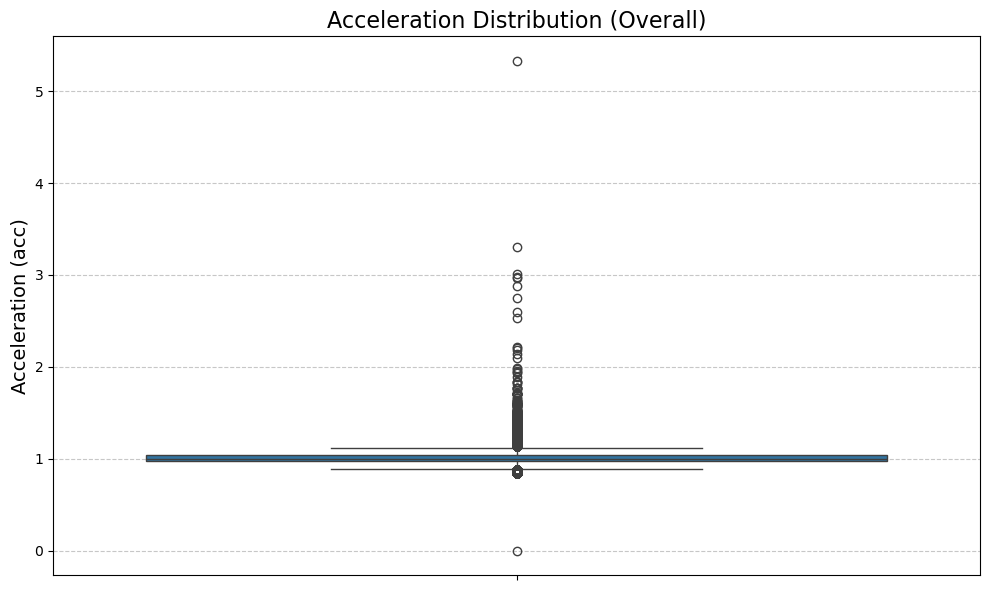

In [20]:
# acc 열의 데이터 타입을 float으로 변환
df['acc'] = pd.to_numeric(df['acc'], errors='coerce')

# 박스플롯 생성
plt.figure(figsize=(10, 6))
sns.boxplot(y='acc', data=df)

# 그래프 제목과 레이블 설정
plt.title('Acceleration Distribution (Overall)', fontsize=16)
plt.ylabel('Acceleration (acc)', fontsize=14)

# 그리드 추가
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()

In [21]:
df[df['acc'] >= 5]

,device_datetime_kor,device_serial,lat,lon,battery,temperature,humidity,acc_orig,acc,accx,accy,accz,tiltx,tilty,tiltz,measure_date_kst,aws_station_id,aws_station_name,aws_lat,aws_lon,distance_km,ws1,ws10,ta,hm
113526,2025-01-23 08:37:35,VC6M6038,36.626770,127.221254,30.0,0.7,80.0,5.3,5.33,-2.8,-0.6,-4.5,-14.7,0.3,75.3,2025-01-23 08:00:00,629,세종전의,36.69076000,127.20047000,7.340217,0.00,0.00,-6.70,93.30


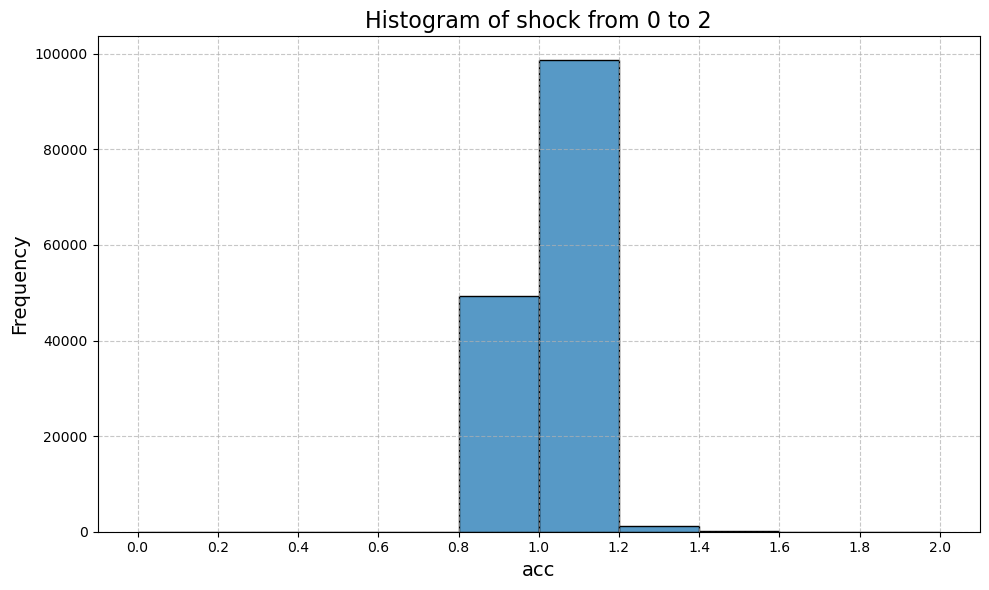

In [22]:
# 히스토그램 생성
plt.figure(figsize=(10, 6))
sns.histplot(df['acc'], bins=np.arange(0, 2.2, 0.2), kde=False)  # 0.2 단위로 구간 설정

# 그래프 제목과 레이블 설정
plt.title('Histogram of shock from 0 to 2', fontsize=16)
plt.xlabel('acc', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# x축 눈금을 0.2 단위로 설정
plt.xticks(np.arange(0, 2.1, 0.2))

# 그리드 추가
plt.grid(True, linestyle='--', alpha=0.7)

# 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()

In [23]:
print(acc_final_stats.head(2))
print(temp_final_stats.head(2))
print(humi_final_stats.head(2))

                count  mean   std   min    Q1  median    Q3   max  \
device_serial                                                       
VC6M6034       1227.0  1.16  0.10  0.88  1.06     1.2  1.21  1.81   
VC6M6068         41.0  1.05  0.11  1.00  1.00     1.0  1.00  1.40   

               Whisker Start  Whisker End  
device_serial                              
VC6M6034                0.84         1.43  
VC6M6068                1.00         1.00  
                 std  count  min   max   mean   Q1    Q3   IQR  Whisker Start  \
device_serial                                                                   
VC6M6034       51.31   1227 -5.5  21.3  12.81  7.5  20.1  12.6         -11.40   
VC6M6068        0.48     41  6.4   8.7   7.44  6.8   8.1   1.3           4.85   

               Whisker End  
device_serial               
VC6M6034             39.00  
VC6M6068             10.05  
                count   mean   std   min    Q1  median    Q3   max  \
device_serial                       

In [24]:
merged_temp_humi=[]
# 첫 번째 병합: temp_final_stats와 humi_final_stats 병합
merged_temp_humi = pd.merge(temp_final_stats, humi_final_stats, on='device_serial', suffixes=('_temp', '_humi'))

# 두 번째 병합: 첫 번째 병합 결과와 acc_final_stats 병합
merged_stats = pd.merge(merged_temp_humi, acc_final_stats, on='device_serial', suffixes=('', '_acc'))

merged_stats.head(3)

,std_temp,count_temp,min_temp,max_temp,mean_temp,Q1_temp,Q3_temp,IQR,Whisker Start_temp,Whisker End_temp,count_humi,mean_humi,std_humi,min_humi,Q1_humi,median,Q3_humi,max_humi,Whisker Start_humi,Whisker End_humi,count,mean,std,min,Q1,median_acc,Q3,max,Whisker Start,Whisker End
device_serial,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
VC6M6034,51.31,1227,-5.5,21.3,12.81,7.5,20.1,12.6,-11.40,39.00,1227.0,53.30,8.78,32.0,46.0,57.0,60.0,87.0,25.0,81.0,1227.0,1.16,0.10,0.88,1.06,1.2,1.21,1.81,0.84,1.43
VC6M6068,0.48,41,6.4,8.7,7.44,6.8,8.1,1.3,4.85,10.05,41.0,73.02,1.52,69.0,72.0,73.0,73.0,78.0,70.5,74.5,41.0,1.05,0.11,1.00,1.00,1.0,1.00,1.40,1.00,1.00
VC6M6094,8.97,257,8.2,21.1,13.32,11.6,14.9,3.3,6.65,19.85,257.0,57.32,6.28,40.0,55.0,60.0,62.0,65.0,44.5,72.5,257.0,1.12,0.07,1.10,1.10,1.1,1.10,1.66,1.10,1.10


In [25]:
merged_stats.info()

<class 'pandas.core.frame.DataFrame'>
Index: 156 entries, VC6M6034 to VC6M61ED
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   std_temp            156 non-null    float64
 1   count_temp          156 non-null    int64  
 2   min_temp            156 non-null    float64
 3   max_temp            156 non-null    float64
 4   mean_temp           156 non-null    float64
 5   Q1_temp             156 non-null    float64
 6   Q3_temp             156 non-null    float64
 7   IQR                 156 non-null    float64
 8   Whisker Start_temp  156 non-null    float64
 9   Whisker End_temp    156 non-null    float64
 10  count_humi          156 non-null    float64
 11  mean_humi           156 non-null    float64
 12  std_humi            156 non-null    float64
 13  min_humi            156 non-null    float64
 14  Q1_humi             156 non-null    float64
 15  median              156 non-null    float64
 16  Q

In [26]:
# 새로운 컬럼 생성: 상한온도, 하한온도, 상한습도, 하한습도
merged_stats['temp_end'] = merged_stats['Whisker End_temp']
merged_stats['temp_start'] = merged_stats['Whisker Start_temp']
merged_stats['humi_end'] = merged_stats['Whisker End_humi']
merged_stats['humi_start'] = merged_stats['Whisker Start_humi']
merged_stats['acc_end'] = merged_stats['Whisker End']
merged_stats['acc_start'] = merged_stats['Whisker Start']
merged_stats['std_acc'] = merged_stats['std']
merged_stats['mean_acc'] = merged_stats['mean']
merged_stats['min_acc'] = merged_stats['min']
merged_stats['max_acc'] = merged_stats['max']
merged_stats['Q1_acc'] = merged_stats['Q1']
merged_stats['Q3_acc'] = merged_stats['Q3']

In [27]:
merged_stats.head(2)

,std_temp,count_temp,min_temp,max_temp,mean_temp,Q1_temp,Q3_temp,IQR,Whisker Start_temp,Whisker End_temp,count_humi,mean_humi,std_humi,min_humi,Q1_humi,median,Q3_humi,max_humi,Whisker Start_humi,Whisker End_humi,count,mean,std,min,Q1,median_acc,Q3,max,Whisker Start,Whisker End,temp_end,temp_start,humi_end,humi_start,acc_end,acc_start,std_acc,mean_acc,min_acc,max_acc,Q1_acc,Q3_acc
device_serial,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
VC6M6034,51.31,1227,-5.5,21.3,12.81,7.5,20.1,12.6,-11.40,39.00,1227.0,53.30,8.78,32.0,46.0,57.0,60.0,87.0,25.0,81.0,1227.0,1.16,0.10,0.88,1.06,1.2,1.21,1.81,0.84,1.43,39.00,-11.40,81.0,25.0,1.43,0.84,0.10,1.16,0.88,1.81,1.06,1.21
VC6M6068,0.48,41,6.4,8.7,7.44,6.8,8.1,1.3,4.85,10.05,41.0,73.02,1.52,69.0,72.0,73.0,73.0,78.0,70.5,74.5,41.0,1.05,0.11,1.00,1.00,1.0,1.00,1.40,1.00,1.00,10.05,4.85,74.5,70.5,1.00,1.00,0.11,1.05,1.00,1.40,1.00,1.00


In [28]:
merged_stats.info()

<class 'pandas.core.frame.DataFrame'>
Index: 156 entries, VC6M6034 to VC6M61ED
Data columns (total 42 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   std_temp            156 non-null    float64
 1   count_temp          156 non-null    int64  
 2   min_temp            156 non-null    float64
 3   max_temp            156 non-null    float64
 4   mean_temp           156 non-null    float64
 5   Q1_temp             156 non-null    float64
 6   Q3_temp             156 non-null    float64
 7   IQR                 156 non-null    float64
 8   Whisker Start_temp  156 non-null    float64
 9   Whisker End_temp    156 non-null    float64
 10  count_humi          156 non-null    float64
 11  mean_humi           156 non-null    float64
 12  std_humi            156 non-null    float64
 13  min_humi            156 non-null    float64
 14  Q1_humi             156 non-null    float64
 15  median              156 non-null    float64
 16  Q

In [29]:
col_lst=['min_temp', 'max_temp', 'mean_temp', 'std_temp'
         , 'min_humi', 'max_humi', 'mean_humi', 'std_humi'
         , 'min_acc', 'max_acc', 'mean_acc', 'std_acc'
         , 'Q1_temp', 'Q3_temp', 'temp_start', 'temp_end'
         , 'Q1_humi', 'Q3_humi', 'humi_start', 'humi_end'
         , 'Q1_acc', 'Q3_acc', 'acc_start', 'acc_end']
low_upp=merged_stats[col_lst]

In [30]:
low_upp.head(2)

,min_temp,max_temp,mean_temp,std_temp,min_humi,max_humi,mean_humi,std_humi,min_acc,max_acc,mean_acc,std_acc,Q1_temp,Q3_temp,temp_start,temp_end,Q1_humi,Q3_humi,humi_start,humi_end,Q1_acc,Q3_acc,acc_start,acc_end
device_serial,,,,,,,,,,,,,,,,,,,,,,,,
VC6M6034,-5.5,21.3,12.81,51.31,32.0,87.0,53.30,8.78,0.88,1.81,1.16,0.10,7.5,20.1,-11.40,39.00,46.0,60.0,25.0,81.0,1.06,1.21,0.84,1.43
VC6M6068,6.4,8.7,7.44,0.48,69.0,78.0,73.02,1.52,1.00,1.40,1.05,0.11,6.8,8.1,4.85,10.05,72.0,73.0,70.5,74.5,1.00,1.00,1.00,1.00


In [31]:
df.head(2)

,device_datetime_kor,device_serial,lat,lon,battery,temperature,humidity,acc_orig,acc,accx,accy,accz,tiltx,tilty,tiltz,measure_date_kst,aws_station_id,aws_station_name,aws_lat,aws_lon,distance_km,ws1,ws10,ta,hm
0,2024-11-19 16:54:08,VC6M60A9,36.845154,127.048707,100.0,12.9,41.0,1.2,1.20,0.0,-1.2,0.0,-2.9,-87.0,0.5,2024-11-19 16:00:00,617,직산,36.89056000,127.14556000,9.998522,1.90,1.70,10.80,47.30
1,2024-12-17 22:41:47,VC6M60AD,36.815106,127.061828,100.0,2.0,48.0,1.0,1.01,0.1,0.1,1.0,2.8,3.6,-85.5,2024-12-17 22:00:00,493,송악,36.73615000,127.00805000,9.991122,0.90,1.50,0.90,63.50


In [32]:
# low_upp 데이터프레임을 df와 병합하여 temp_start와 temp_end를 df에 추가
df_merge=pd.merge(df, low_upp, on='device_serial', how='left')

In [33]:
df_merge.head(2)

,device_datetime_kor,device_serial,lat,lon,battery,temperature,humidity,acc_orig,acc,accx,accy,accz,tiltx,tilty,tiltz,measure_date_kst,aws_station_id,aws_station_name,aws_lat,aws_lon,distance_km,ws1,ws10,ta,hm,min_temp,max_temp,mean_temp,std_temp,min_humi,max_humi,mean_humi,std_humi,min_acc,max_acc,mean_acc,std_acc,Q1_temp,Q3_temp,temp_start,temp_end,Q1_humi,Q3_humi,humi_start,humi_end,Q1_acc,Q3_acc,acc_start,acc_end
0,2024-11-19 16:54:08,VC6M60A9,36.845154,127.048707,100.0,12.9,41.0,1.2,1.20,0.0,-1.2,0.0,-2.9,-87.0,0.5,2024-11-19 16:00:00,617,직산,36.89056000,127.14556000,9.998522,1.90,1.70,10.80,47.30,4.8,13.2,8.23,4.67,37.0,56.0,53.45,3.12,1.0,1.40,1.11,0.05,6.525,9.675,1.80,14.40,53.0,55.0,50.0,58.0,1.1,1.1,1.1,1.1
1,2024-12-17 22:41:47,VC6M60AD,36.815106,127.061828,100.0,2.0,48.0,1.0,1.01,0.1,0.1,1.0,2.8,3.6,-85.5,2024-12-17 22:00:00,493,송악,36.73615000,127.00805000,9.991122,0.90,1.50,0.90,63.50,-2.2,25.4,21.41,11.18,12.0,56.0,20.63,4.94,1.0,1.44,1.00,0.02,20.800,23.100,17.35,26.55,17.0,23.0,8.0,32.0,1.0,1.0,1.0,1.0


### 온도/습도/충격량 일탈여부 정의

#### device_serial별로 사분위수를 넘어가는 케이스에 대해서 일탈로 간주함(온도, 습도)
#### 파손여부는 충격량의 특정 임계치를 넘어간 경우에 대해 정의함 (ex: 충격량(acc)이 1.5를 초과하는 경우 파손이라 함)

In [34]:
## 일탈/파손: 1
## 정상: 0

# 온도 일탈 여부 확인: temp_start와 temp_end를 벗어나는 경우
df_merge['alert_temp'] = df_merge.apply(lambda row: 1 if row['temperature'] < row['temp_start'] or row['temperature'] > row['temp_end'] else 0, axis=1)
# 습도 일탈 여부 확인: humi_start와 humi_end를 벗어나는 경우
df_merge['alert_humi'] = df_merge.apply(lambda row: 1 if row['humidity'] < row['humi_start'] or row['humidity'] > row['humi_end'] else 0, axis=1)
# 충격 일탈 여부 확인: acc_start와 acc_end를 벗어나는 경우
df_merge['alert_acc'] = df_merge.apply(lambda row: 1 if row['acc'] < row['acc_start'] or row['acc'] > row['acc_end'] else 0, axis=1)
# 충격 일탈 여부 확인: acc_start와 acc_end를 벗어나는 경우 및 실제 측정값이 1.5 초과 시 파손으로 확인
df_merge['item_shock'] = df_merge.apply(lambda row: 1 if row['acc'] > 1.5 else 0, axis=1)

# 온도 결과 출력
print("온도 일탈 여부:")
print(df_merge[['device_serial', 'temperature', 'alert_temp', 'temp_start', 'temp_end']])

# 습도 결과 출력
print("습도 일탈 여부:")
print(df_merge[['device_serial', 'humidity', 'alert_humi', 'humi_start', 'humi_end']])

# 충격량 결과 출력
print("충격량 일탈 여부:")
print(df_merge[['device_serial', 'acc', 'alert_acc', 'acc_start', 'humi_end']])

# 파손여부 결과 출력
print("파손 여부:")
print(df_merge[['device_serial', 'acc', 'item_shock']])

온도 일탈 여부:
       device_serial  temperature  alert_temp  temp_start  temp_end
0           VC6M60A9         12.9           0        1.80     14.40
1           VC6M60AD          2.0           1       17.35     26.55
2           VC6M60AD          1.7           1       17.35     26.55
3           VC6M60AD          1.4           1       17.35     26.55
4           VC6M60AD          1.3           1       17.35     26.55
...              ...          ...         ...         ...       ...
149240      VC6M60E6          5.1           0       -2.40     12.80
149241      VC6M60E6          5.1           0       -2.40     12.80
149242      VC6M6002         15.3           0       -0.30     18.90
149243      VC6ML003          6.1           1       17.00     25.80
149244      VC6M6049          3.4           0       -8.80     21.60

[149245 rows x 5 columns]
습도 일탈 여부:
       device_serial  humidity  alert_humi  humi_start  humi_end
0           VC6M60A9      41.0           1        50.0      58.0
1      

In [35]:
len(df_merge.columns)

53

In [36]:
col_lst = ['device_datetime_kor', 'device_serial', 'lat', 'lon', 'battery'
           , 'temperature', 'humidity', 'acc_orig', 'acc', 'accx', 'accy', 'accz'
           , 'tiltx', 'tilty', 'tiltz', 'measure_date_kst', 'aws_station_id'
           , 'aws_station_name', 'aws_lat', 'aws_lon', 'distance_km', 'ws1', 'ws10', 'ta', 'hm'
           , 'min_temp', 'max_temp', 'mean_temp', 'std_temp'
           , 'min_humi', 'max_humi', 'mean_humi', 'std_humi'
           , 'min_acc', 'max_acc', 'mean_acc', 'std_acc'
           , 'Q1_temp', 'Q3_temp', 'temp_start', 'temp_end'
           , 'Q1_humi', 'Q3_humi', 'humi_start', 'humi_end'
           , 'Q1_acc', 'Q3_acc', 'acc_start', 'acc_end'
           , 'alert_temp', 'alert_humi', 'alert_acc', 'item_shock']

df_merge_2 = df_merge[col_lst]
print(df_merge_2.head(2))

  device_datetime_kor device_serial        lat         lon battery  \
0 2024-11-19 16:54:08      VC6M60A9  36.845154  127.048707   100.0   
1 2024-12-17 22:41:47      VC6M60AD  36.815106  127.061828   100.0   

   temperature  humidity acc_orig   acc accx  accy accz tiltx  tilty  tiltz  \
0         12.9      41.0      1.2  1.20  0.0  -1.2  0.0  -2.9  -87.0    0.5   
1          2.0      48.0      1.0  1.01  0.1   0.1  1.0   2.8    3.6  -85.5   

     measure_date_kst  aws_station_id aws_station_name      aws_lat  \
0 2024-11-19 16:00:00             617               직산  36.89056000   
1 2024-12-17 22:00:00             493               송악  36.73615000   

        aws_lon  distance_km   ws1  ws10     ta     hm  min_temp  max_temp  \
0  127.14556000     9.998522  1.90  1.70  10.80  47.30       4.8      13.2   
1  127.00805000     9.991122  0.90  1.50   0.90  63.50      -2.2      25.4   

   mean_temp  std_temp  min_humi  max_humi  mean_humi  std_humi  min_acc  \
0       8.23      4.67    

In [37]:
# device_serial별로 시작시간과 끝시간 추출
df_start_end = df_merge_2.groupby('device_serial')['device_datetime_kor'].agg(['min', 'max']).reset_index()
# 컬럼명 변경
df_start_end.columns = ['device_serial', 'start_date', 'end_date']
df_fin = df_merge.merge(df_start_end, on='device_serial', how='left')

## Data insert

#### Data Split

### df_alert 정보 추출을 위한 데이터 정제

In [39]:
# 알람에 필요한 
alert_lst = ['device_datetime_kor', 'device_serial', 'lat', 'lon', 'battery', 'temperature', 'humidity', 'acc_orig', 'acc', 'accx', 'accy', 'accz', 'tiltx', 'tilty', 'tiltz'
             , 'measure_date_kst', 'aws_station_id', 'aws_station_name', 'aws_lat', 'aws_lon', 'distance_km', 'ws1', 'ws10', 'ta', 'hm', 'alert_temp', 'alert_humi', 'alert_acc', 'item_shock']
df_alert_fin = df_fin[alert_lst]


In [43]:
df_alert_fin

,device_datetime_kor,device_serial,lat,lon,battery,temperature,humidity,acc_orig,acc,accx,accy,accz,tiltx,tilty,tiltz,measure_date_kst,aws_station_id,aws_station_name,aws_lat,aws_lon,distance_km,ws1,ws10,ta,hm,alert_temp,alert_humi,alert_acc,item_shock
0,2024-11-19 16:54:08,VC6M60A9,36.845154,127.048707,100.0,12.9,41.0,1.2,1.20,0.0,-1.2,0.0,-2.9,-87.0,0.5,2024-11-19 16:00:00,617,직산,36.89056000,127.14556000,9.998522,1.90,1.70,10.80,47.30,0,1,1,0
1,2024-12-17 22:41:47,VC6M60AD,36.815106,127.061828,100.0,2.0,48.0,1.0,1.01,0.1,0.1,1.0,2.8,3.6,-85.5,2024-12-17 22:00:00,493,송악,36.73615000,127.00805000,9.991122,0.90,1.50,0.90,63.50,1,1,1,0
2,2024-12-17 22:51:47,VC6M60AD,36.815106,127.061828,100.0,1.7,48.0,1.0,1.01,0.1,0.1,1.0,2.6,3.4,-85.8,2024-12-17 22:00:00,493,송악,36.73615000,127.00805000,9.991122,0.90,1.50,0.90,63.50,1,1,1,0
3,2024-12-17 23:01:47,VC6M60AD,36.815106,127.061828,100.0,1.4,48.0,1.0,1.01,0.1,0.1,1.0,2.7,3.7,-85.4,2024-12-17 23:00:00,493,송악,36.73615000,127.00805000,9.991122,2.30,1.70,0.50,60.50,1,1,1,0
4,2024-12-17 23:11:47,VC6M60AD,36.815106,127.061828,100.0,1.3,49.0,1.0,1.01,0.1,0.1,1.0,2.9,3.5,-85.5,2024-12-17 23:00:00,493,송악,36.73615000,127.00805000,9.991122,2.30,1.70,0.50,60.50,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149240,2024-12-13 12:51:44,VC6M60E6,36.299017,127.593702,100.0,5.1,40.0,1.0,1.00,0.0,-1.0,0.0,-1.9,-87.9,0.9,2024-12-13 12:00:00,604,옥천,36.29995000,127.59654000,0.275135,1.70,0.80,3.60,34.20,0,0,0,0
149241,2024-12-13 13:01:44,VC6M60E6,36.299017,127.593702,100.0,5.1,40.0,1.1,1.10,0.0,-1.1,0.0,0.0,-87.8,-2.2,2024-12-13 13:00:00,604,옥천,36.29995000,127.59654000,0.275135,1.70,1.60,3.60,36.70,0,0,1,0
149242,2024-12-02 16:57:18,VC6M6002,36.298510,127.597675,100.0,15.3,62.0,1.2,1.20,0.0,-1.2,0.0,0.9,-88.8,0.7,2024-12-02 16:00:00,604,옥천,36.29995000,127.59654000,0.189542,1.90,2.30,14.90,52.50,0,0,1,0
149243,2024-12-09 11:53:19,VC6ML003,36.638253,127.384396,100.0,6.1,43.0,1.2,1.21,-0.1,0.1,1.2,-4.2,-1.0,-85.6,2024-12-09 11:00:00,181,서청주,36.63994000,127.38458000,0.187931,1.20,1.10,2.20,67.20,1,1,1,0


### df_broken 정보 추출을 위한 데이터 정제

In [40]:
broken_lst = ['device_serial', 'start_date', 'end_date', 'min_temp', 'max_temp', 'mean_temp', 'std_temp', 'min_humi', 'max_humi', 'mean_humi', 'std_humi', 'min_acc', 'max_acc', 'mean_acc'
              , 'std_acc', 'Q1_temp', 'Q3_temp', 'temp_start', 'temp_end', 'Q1_humi', 'Q3_humi', 'humi_start', 'humi_end', 'Q1_acc', 'Q3_acc', 'acc_start', 'acc_end', 'item_shock']
df_broken_fin=df_fin[broken_lst]
df_broken_fin_unique = df_broken_fin.drop_duplicates()
df_broken_fin_unique.head(2)

,device_serial,start_date,end_date,min_temp,max_temp,mean_temp,std_temp,min_humi,max_humi,mean_humi,std_humi,min_acc,max_acc,mean_acc,std_acc,Q1_temp,Q3_temp,temp_start,temp_end,Q1_humi,Q3_humi,humi_start,humi_end,Q1_acc,Q3_acc,acc_start,acc_end,item_shock
0,VC6M60A9,2024-11-19 16:24:08,2024-11-21 17:34:08,4.8,13.2,8.23,4.67,37.0,56.0,53.45,3.12,1.0,1.40,1.11,0.05,6.525,9.675,1.80,14.40,53.0,55.0,50.0,58.0,1.1,1.1,1.1,1.1,0
1,VC6M60AD,2024-12-17 10:51:47,2025-01-23 23:51:47,-2.2,25.4,21.41,11.18,12.0,56.0,20.63,4.94,1.0,1.44,1.00,0.02,20.800,23.100,17.35,26.55,17.0,23.0,8.0,32.0,1.0,1.0,1.0,1.0,0


#### 소요시간 정보(시간, 일 기준) 추출

In [41]:
# start_date와 end_date를 datetime 형식으로 변환
df_broken_fin_unique['start_date'] = pd.to_datetime(df_broken_fin_unique['start_date'])
df_broken_fin_unique['end_date'] = pd.to_datetime(df_broken_fin_unique['end_date'])

# duration_time을 시간 단위로 계산
df_broken_fin_unique['duration_time'] = (df_broken_fin_unique['end_date'] - df_broken_fin_unique['start_date']).dt.total_seconds() / 3600

# duration_day를 소요일로 계산
df_broken_fin_unique['duration_day'] = (df_broken_fin_unique['end_date'] - df_broken_fin_unique['start_date']).dt.days

In [42]:
df_broken_fin_unique

,device_serial,start_date,end_date,min_temp,max_temp,mean_temp,std_temp,min_humi,max_humi,mean_humi,std_humi,min_acc,max_acc,mean_acc,std_acc,Q1_temp,Q3_temp,temp_start,temp_end,Q1_humi,Q3_humi,humi_start,humi_end,Q1_acc,Q3_acc,acc_start,acc_end,item_shock,duration_time,duration_day
0,VC6M60A9,2024-11-19 16:24:08,2024-11-21 17:34:08,4.8,13.2,8.23,4.67,37.0,56.0,53.45,3.12,1.0,1.40,1.11,0.05,6.525,9.675,1.800,14.400,53.0,55.0,50.00,58.00,1.1,1.10,1.10,1.10,0,49.166667,2
1,VC6M60AD,2024-12-17 10:51:47,2025-01-23 23:51:47,-2.2,25.4,21.41,11.18,12.0,56.0,20.63,4.94,1.0,1.44,1.00,0.02,20.800,23.100,17.350,26.550,17.0,23.0,8.00,32.00,1.0,1.00,1.00,1.00,0,901.000000,37
31,VC6M60ED,2024-11-30 04:44:42,2024-12-03 23:44:42,1.0,7.8,3.38,7.43,53.0,75.0,66.27,8.76,1.1,1.43,1.15,0.09,1.550,7.100,-6.775,15.425,54.0,72.0,27.00,99.00,1.1,1.20,0.95,1.35,0,91.000000,3
32,VC6M60E4,2024-12-06 13:58:23,2024-12-07 08:38:23,0.8,12.2,4.83,12.28,36.0,49.0,46.33,4.19,1.1,1.72,1.15,0.11,2.250,6.500,-4.125,12.875,45.5,49.0,40.25,54.25,1.1,1.10,1.10,1.10,0,18.666667,0
33,VC6M6068,2024-11-21 01:11:12,2024-11-21 08:21:12,6.4,8.7,7.44,0.48,69.0,78.0,73.02,1.52,1.0,1.40,1.05,0.11,6.800,8.100,4.850,10.050,72.0,73.0,70.50,74.50,1.0,1.00,1.00,1.00,0,7.166667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136092,VC6M60C1,2024-12-02 14:06:09,2024-12-09 00:26:09,2.2,18.1,8.33,14.65,49.0,66.0,59.01,3.65,1.0,1.56,1.01,0.05,5.600,10.700,-2.050,18.350,56.0,61.0,48.50,68.50,1.0,1.00,1.00,1.00,1,154.333333,6
140210,VC6M6019,2024-12-07 14:28:49,2024-12-10 20:28:49,-4.5,9.4,0.77,14.54,35.0,51.0,45.71,3.92,1.0,1.70,1.01,0.05,-2.125,3.375,-10.375,11.625,44.0,48.0,38.00,54.00,1.0,1.00,1.00,1.00,1,78.000000,3
142747,VC6M6003,2024-12-14 09:40:13,2025-01-23 23:50:13,-0.1,19.8,6.83,14.00,37.0,66.0,56.53,7.61,1.0,1.52,1.02,0.06,3.900,9.000,-3.750,16.650,49.0,62.0,29.50,81.50,1.0,1.01,0.98,1.02,1,974.166667,40
143070,VC6M60E4,2024-12-06 13:58:23,2024-12-07 08:38:23,0.8,12.2,4.83,12.28,36.0,49.0,46.33,4.19,1.1,1.72,1.15,0.11,2.250,6.500,-4.125,12.875,45.5,49.0,40.25,54.25,1.1,1.10,1.10,1.10,1,18.666667,0


# Table Create Query
<!-- CREATE TABLE "da_schema"."t_frigga_weather_map_alert" (
    device_datetime_kor TIMESTAMP WITHOUT TIME ZONE ENCODE raw,
    device_serial VARCHAR(255) ENCODE raw,
    lat NUMERIC(10, 6) ENCODE az64,
    lon NUMERIC(10, 6) ENCODE az64,
    battery NUMERIC(10, 1) ENCODE az64,
    temperature NUMERIC(10, 1) ENCODE az64,
    humidity NUMERIC(10, 1) ENCODE az64,
    acc_orig NUMERIC(10, 1) ENCODE az64,
    acc DOUBLE PRECISION ENCODE raw,
    accx NUMERIC(10, 1) ENCODE az64,
    accy NUMERIC(10, 1) ENCODE az64,
    accz NUMERIC(10, 1) ENCODE az64,
    tiltx NUMERIC(10, 1) ENCODE az64,
    tilty NUMERIC(10, 1) ENCODE az64,
    tiltz NUMERIC(10, 1) ENCODE az64,
    measure_date_kst TIMESTAMP WITHOUT TIME ZONE ENCODE az64,
    aws_station_id INTEGER ENCODE az64,
    aws_station_name VARCHAR(100) ENCODE lzo,
    aws_lat NUMERIC(11, 8) ENCODE az64,
    aws_lon NUMERIC(11, 8) ENCODE az64,
    distance_km DOUBLE PRECISION ENCODE raw,
    ws1 NUMERIC(10, 2) ENCODE az64,
    ws10 NUMERIC(10, 2) ENCODE az64,
    ta NUMERIC(10, 2) ENCODE az64,
    hm NUMERIC(10, 2) ENCODE az64, 
    Q1_temp NUMERIC(10, 2) ENCODE az64,
    Q3_temp NUMERIC(10, 2) ENCODE az64,
    temp_start NUMERIC(10, 2) ENCODE az64,
    temp_end NUMERIC(10, 2) ENCODE az64,
    Q1_humi NUMERIC(10, 2) ENCODE az64,
    Q3_humi NUMERIC(10, 2) ENCODE az64,
    humi_start NUMERIC(10, 2) ENCODE az64,
    humi_end NUMERIC(10, 2) ENCODE az64,
    alert_temp VARCHAR(255) ENCODE lzo,
    alert_humi VARCHAR(255) ENCODE lzo
)
DISTSTYLE AUTO
SORTKEY (device_serial, device_datetime_kor); -->

In [56]:
import psycopg2
from psycopg2.extras import execute_values
from tqdm import tqdm

### df_fin INSERT

In [41]:
df_fin.columns

Index(['device_datetime_kor', 'device_serial', 'lat', 'lon', 'battery',
       'temperature', 'humidity', 'acc_orig', 'acc', 'accx', 'accy', 'accz',
       'tiltx', 'tilty', 'tiltz', 'measure_date_kst', 'aws_station_id',
       'aws_station_name', 'aws_lat', 'aws_lon', 'distance_km', 'ws1', 'ws10',
       'ta', 'hm', 'min_temp', 'max_temp', 'mean_temp', 'std_temp', 'min_humi',
       'max_humi', 'mean_humi', 'std_humi', 'min_acc', 'max_acc', 'mean_acc',
       'std_acc', 'Q1_temp', 'Q3_temp', 'temp_start', 'temp_end', 'Q1_humi',
       'Q3_humi', 'humi_start', 'humi_end', 'Q1_acc', 'Q3_acc', 'acc_start',
       'acc_end', 'alert_temp', 'alert_humi', 'alert_acc', 'item_shock',
       'start_date', 'end_date'],
      dtype='object')

In [49]:
# Redshift에 연결
conn = psycopg2.connect(
    host='',
    dbname='',
    user='',
    password='',
    port=''
)

# 데이터프레임을 튜플 리스트로 변환
values = [tuple(row) for row in df_merge.values]

# INSERT 쿼리
insert_query = """
    INSERT INTO "data_analysis_db"."da_schema"."t_frigga_weather_map_alert" (
       device_datetime_kor, device_serial, lat, lon, battery,
       temperature, humidity, acc_orig, acc, accx, accy, accz,
       tiltx, tilty, tiltz, measure_date_kst, aws_station_id,
       aws_station_name, aws_lat, aws_lon, distance_km, ws1, ws10,
       ta, hm, min_temp, max_temp, mean_temp, std_temp, min_humi,
       max_humi, mean_humi, std_humi, min_acc, max_acc, mean_acc,
       std_acc, Q1_temp, Q3_temp, temp_start, temp_end, Q1_humi,
       Q3_humi, humi_start, humi_end, Q1_acc, Q3_acc, acc_start,
       acc_end, alert_temp, alert_humi, alert_acc, item_shock
    ) VALUES %s
"""

try:
    # 커서 생성
    cursor = conn.cursor()

    # execute_values를 사용하여 한 번에 여러 행 삽입
    # tqdm을 사용하여 진행 상황 표시
    for i in tqdm(range(0, len(values), 1000), desc="Inserting data"):
        execute_values(cursor, insert_query, values[i:i + 1000])
    
    # 커밋하여 변경 사항을 적용
    conn.commit()
    print("데이터 INSERT 완료")

except Exception as e:
    conn.rollback()
    print(f"에러 발생: {str(e)}")

finally:
    # 커서와 연결 종료
    if cursor:
        cursor.close()
    if conn:
        conn.close()

Inserting data: 100%|██████████| 147/147 [05:02<00:00,  2.06s/it]


데이터 INSERT 완료


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## df_alert INSERT

In [69]:
# Redshift에 연결
conn = psycopg2.connect(
    host='',
    dbname='',
    user='',
    password='',
    port=''
)

# 데이터프레임을 튜플 리스트로 변환
values = [tuple(row) for row in df_alert_fin.values]

# INSERT 쿼리
insert_query = """
        INSERT INTO "data_analysis_db"."da_schema"."t_frigga_alert_target" ( 
            "device_datetime_kor", "device_serial", "lat", "lon", "battery", "temperature", "humidity", "acc_orig", "acc", "accx", "accy", "accz", "tiltx", "tilty", "tiltz",
            "measure_date_kst", "aws_station_id", "aws_station_name", "aws_lat", "aws_lon", "distance_km", "ws1", "ws10", "ta", "hm", "alert_temp", "alert_humi", "alert_acc", "item_shock"
        ) VALUES %s
"""

try:
    # 커서 생성
    cursor = conn.cursor()

    # execute_values를 사용하여 한 번에 여러 행 삽입
    # tqdm을 사용하여 진행 상황 표시
    for i in tqdm(range(0, len(values), 1000), desc="Inserting data"):
        execute_values(cursor, insert_query, values[i:i + 1000])
    
    # 커밋하여 변경 사항을 적용
    conn.commit()
    print("데이터 INSERT 완료")

except Exception as e:
    conn.rollback()
    print(f"에러 발생: {str(e)}")

finally:
    # 커서와 연결 종료
    if cursor:
        cursor.close()
    if conn:
        conn.close()
        

Inserting data: 100%|██████████| 150/150 [04:42<00:00,  1.89s/it]


데이터 INSERT 완료


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## df_broken INSERT

In [ ]:
df_broken_fin_unique.columns

In [40]:
lst= ['device_serial', 'start_date', 'end_date', 'duration_time', 'duration_day', 'min_temp', 'max_temp', 'mean_temp', 'std_temp', 'min_humi', 'max_humi', 'mean_humi',
       'std_humi', 'min_acc', 'max_acc', 'mean_acc', 'std_acc', 'Q1_temp', 'Q3_temp', 'temp_start', 'temp_end', 'Q1_humi', 'Q3_humi', 'humi_start',
       'humi_end', 'Q1_acc', 'Q3_acc', 'acc_start', 'acc_end', 'item_shock']
broken_fin=df_broken_fin_unique[lst]

In [62]:
# 2. alert_temp, alert_humi, alert_acc의 합계 계산
alert_sums = df_alert_fin.groupby('device_serial').agg({
    'alert_temp': 'sum',
    'alert_humi': 'sum',
    'alert_acc': 'sum'
}).reset_index()

# 3. 컬럼명 변경
alert_sums.columns = ['device_serial', 'alert_temp_sum', 'alert_humi_sum', 'alert_acc_sum']

# 4. broken_YN 계산: 발생 유무에 따라 1 또는 0 할당
broken_YN = df_broken_fin.groupby('device_serial')['item_shock'].apply(lambda x: 1 if (x == 1).any() else 0).reset_index()
broken_YN.columns = ['device_serial', 'broken_yn']

# 5. df_broken_fin과 병합하여 새로운 컬럼 추가
df_broken_fin = broken_fin.merge(alert_sums, on='device_serial', how='left')
df_broken_fin = df_broken_fin.merge(broken_YN, on='device_serial', how='left')

In [63]:
df_shock_fin = df_broken_fin.drop_duplicates()


In [67]:
print(df_shock_fin.head(5))
print('--------------------------')
print(df_shock_fin.columns)
print(df_shock_fin.shape)
print(df_shock_fin.info())

  device_serial          start_date            end_date  duration_time  \
0      VC6M60A9 2024-11-19 16:24:08 2024-11-21 17:34:08      49.166667   
1      VC6M60AD 2024-12-17 10:51:47 2025-01-23 23:51:47     901.000000   
2      VC6M60ED 2024-11-30 04:44:42 2024-12-03 23:44:42      91.000000   
3      VC6M60E4 2024-12-06 13:58:23 2024-12-07 08:38:23      18.666667   
4      VC6M6068 2024-11-21 01:11:12 2024-11-21 08:21:12       7.166667   

   duration_day  min_temp  max_temp  mean_temp  std_temp  min_humi  max_humi  \
0             2       4.8      13.2       8.23      4.67      37.0      56.0   
1            37      -2.2      25.4      21.41     11.18      12.0      56.0   
2             3       1.0       7.8       3.38      7.43      53.0      75.0   
3             0       0.8      12.2       4.83     12.28      36.0      49.0   
4             0       6.4       8.7       7.44      0.48      69.0      78.0   

   mean_humi  std_humi  min_acc  max_acc  mean_acc  std_acc  Q1_temp  Q3_t

In [68]:
# Redshift에 연결
conn = psycopg2.connect(
    host='',
    dbname='',
    user='',
    password='',
    port=''
)

# 데이터프레임을 튜플 리스트로 변환
values = [tuple(row) for row in df_shock_fin.values]

# INSERT 쿼리
insert_query = """
        INSERT INTO "data_analysis_db"."da_schema"."t_frigga_broken_target" ( 
            "device_serial", "start_date", "end_date", 
            "duration_time", "duration_day", 
            "min_temp", "max_temp", "mean_temp", "std_temp", 
            "min_humi", "max_humi", "mean_humi", "std_humi", 
            "min_acc", "max_acc", "mean_acc", "std_acc", 
            "q1_temp", "q3_temp", "temp_start", "temp_end", "q1_humi", "q3_humi", 
            "humi_start", "humi_end", "q1_acc", "q3_acc", "acc_start", "acc_end", "item_shock",
            "alert_temp_sum", "alert_humi_sum", "alert_acc_sum", "broken_yn"
        ) VALUES %s
"""

try:
    # 커서 생성
    cursor = conn.cursor()

    # execute_values를 사용하여 한 번에 여러 행 삽입
    # tqdm을 사용하여 진행 상황 표시
    for i in tqdm(range(0, len(values), 1000), desc="Inserting data"):
        execute_values(cursor, insert_query, values[i:i + 1000])
    
    # 커밋하여 변경 사항을 적용
    conn.commit()
    print("데이터 INSERT 완료")

except Exception as e:
    conn.rollback()
    print(f"에러 발생: {str(e)}")

finally:
    # 커서와 연결 종료
    if cursor:
        cursor.close()
    if conn:
        conn.close()

Inserting data: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


데이터 INSERT 완료
